<a href="https://colab.research.google.com/github/Julianpucheta/OptimalControl/blob/main/Pontryagin%20minimum%20principle/Control_CyO_Pendulo_MH_Octave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Solución del péndulo invertido con control y observador calculado empleando el método de MH

El método MH está desarrollado en el artículo titulado "Controlador óptimo con observación de estados basado en el principio del máximo de Pontryagin de bajo costo computacional" [éste](https://riaa-tecno.unca.edu.ar/handle/123456789/1193). Disponible en éste [Repositorio](https://riaa-tecno.unca.edu.ar/bitstream/handle/123456789/1193/REVISTA%20CODINOA%20N%c2%ba%209_%20%28623-629%29%28PUCHETA%29.pdf?sequence=1&isAllowed=y).


In [1]:
#!apt-get update

In [ ]:
!apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super #Necesario para imprimir Latex en formato dvi, latex etc
#Conviene imprimri separado, porque tiene un diálogo que pide Presionar R y luego X.

In [ ]:
!apt install octave

In [68]:
%%writefile Control_CyO_Pendulo_MH.m
warning('off','all');
clc;clear all;
% Example extracted from: Sontag. Mathematical control theory 1998. Pag 104. http://www.sontaglab.org.
% Pontryagin minimum principle
clc;clear all;close all;
m=.1;Fricc=0.1; long=0.6;g=9.8;M=.5;
h=0.001;tiempo=(120/h);tita_pp=0;
t=0:h:(tiempo)*h;
ref=100;
omega(1)=0; p_p(1)=0; u(1)=0; p(1)=0; i=1;indice=0;
%Version linealizada en el equilibrio inestable. Sontag Pp 104.
% estado=[p(i); p_p(i); alfa(i); omega(i)]
Mat_A=[0 1 0 0;0 -Fricc/M -m*g/M 0; 0 0 0 1; 0 Fricc/(long*M) g*(m+M)/(long*M) 0];
Mat_B=[0; 1/M; 0; -1/(long*M)];
Mat_C=[1 0 0 0;0 0 1 0]; %La salida monovariable es posicion
% Construccion del sistema ampliado
Mat_Aa=[Mat_A zeros(4,1);-Mat_C(1,:) 0];
Mat_Ba=[Mat_B;0];
% Mat_M=[Mat_B Mat_A*Mat_B Mat_A^2*Mat_B Mat_A^3*Mat_B];%Matriz Controlabilidad
Mat_M=[Mat_Ba Mat_Aa*Mat_Ba Mat_Aa^2*Mat_Ba Mat_Aa^3*Mat_Ba Mat_Aa^4*Mat_Ba];%Matriz Controlabilidad
%Calculo del controlador por asignacion de polos
%autovalores ecuacion caracteriatica de A lazo abierto
auto_val=eig(Mat_Aa);
c_ai=conv(conv(conv(conv([1 -auto_val(1)],[1 -auto_val(2)]),[1 -auto_val(3)]),[1 -auto_val(4)]),[1 -auto_val(5)]); %= poly(eig(Mat_A))
% c_ai=poly(auto_val);
Mat_W=[c_ai(5) c_ai(4) c_ai(3) c_ai(2) 1;
    c_ai(4) c_ai(3) c_ai(2) 1 0;
    c_ai(3) c_ai(2) 1 0 0;
    c_ai(2) 1 0 0 0;
    1 0 0 0 0];
Mat_T=Mat_M*Mat_W;
A_controlable=inv(Mat_T)*Mat_Aa*Mat_T; %Verificaci?n de que T est? bien
% 1.0000e+00 1.0724e+01 3.7126e+01 4.8193e+01 3.2590e+01 1.0330e+01 alfa_ia=[1.0000e+00 1.0724e+01 3.7126e+01 4.8193e+01 3.2590e+011.0330e+01];%Ec caract deseadapol=fliplr(alfa_ia(2:6)-c_ai(2:6));
a5=-A_controlable(5,1);%a5
a4=-A_controlable(5,2);%a4
a3=-A_controlable(5,3);
a2=-A_controlable(5,4);
a1=-A_controlable(5,5);
R=1e2;
q5=1e5;
q4=1e5;
q3=1e5;
q2=1e3;
q1=1e1;
Q=diag([q1 q2 q3 q4 q5]);
p1=.5*(-4*a5*R+sqrt((4*a5*R)^2+16*q1*R));
p2=.5*(-4*a4*R+sqrt((4*a4*R)^2+16*q2*R));
p3=.5*(-4*a3*R+sqrt((4*a3*R)^2+16*q3*R));
p4=.5*(-4*a2*R+sqrt((4*a2*R)^2+16*q4*R));
p5=.5*(-3*a1*R+sqrt((3*a1*R)^2+ 8*q5*R));
Ka=(([p1 p2 p3 p4 p5])/(2*R))*inv(Mat_T);
K=Ka(1:4); KI=-Ka(5);
disp('Polos del Controlador:')
eig(Mat_Aa-Mat_Ba*Ka)% break
%Observador---------------------------:
Mat_Adual=Mat_A';
Mat_Bdual=Mat_C'; %'
Mat_Cdual=Mat_B';
Qdual=diag([1 1 1 10000]);
Rdual= 0.01*eye(2) ;%1e4*eye(2); %q4=100000;q3=1000000;q2=10000; q1=1000;
Ha=[Mat_Adual -Mat_Bdual*inv(Rdual)*Mat_Bdual'; -Qdual -Mat_Adual'];
[n,va]=size(Ha);
[V,D]=eig(Ha);MX1X2=[];
for ii=1:n
    if real(D(ii,ii))<0
        MX1X2=[MX1X2 V(:,ii)];
    end
end
MX1=MX1X2(1:n/2,:); MX2=MX1X2(n/2+1:end,:);
P=real(MX2*inv(MX1));
Ko1=(inv(Rdual)*Mat_Bdual'*P)';
disp('Polos del Observador LQR:')
eig(Mat_A-Ko1*Mat_C)
%Observador MH:
%Repito con el Sistema Dual
Mat_Adual=Mat_A'; %'
h_=1e-9*[-1;-1];
Mat_Bdual=Mat_C'*h_;
Mat_Cdual=Mat_B';
Qdual=diag([1 1000 100000 100]); % 10 10000 10000000 10000   las 2 andan
%Anda en Matlab y Julia pero no en Python ni Octave, que queda estable pero r=20
Qdual=diag([1, 10000, 100000, 100]); %Anda en Python y en Octave
% Rdual= 0.01*eye(2) ;%1e4eye(2); %q4=100000;q3=1000000;q2=10000; q1=1000;
Mat_M=[Mat_Bdual Mat_Adual*Mat_Bdual Mat_Adual^2*Mat_Bdual Mat_Adual^3*Mat_Bdual];%Matriz Controlabilidad
auto_val=eig(Mat_Adual);
c_ai=poly(auto_val);
Mat_W=[c_ai(4) c_ai(3) c_ai(2) 1;
    c_ai(3) c_ai(2) 1 0;
    c_ai(2) 1 0 0;
    1 0 0 0];
Mat_T=Mat_M*Mat_W;%
A_controlable=inv(Mat_T)*Mat_Adual*Mat_T; %Verificacion de que T este bien
a4=-A_controlable(4,1);
a3=-A_controlable(4,2);
a2=-A_controlable(4,3);
a1=-A_controlable(4,4);
q4=Qdual(4,4);
q3=Qdual(3,3);
q2=Qdual(2,2);
q1=Qdual(1,1); % Q=diag([q1 q2 q3 q4]);
Ro=0.1e0;
p1=.5*(-4*a4*Ro+sqrt((4*a4*Ro)^2+16*q1*Ro));
p2=.5*(-4*a3*Ro+sqrt((4*a3*Ro)^2+16*q2*Ro));
p3=.5*(-4*a2*Ro+sqrt((4*a2*Ro)^2+16*q3*Ro));
p4=.5*(-3*a1*Ro+sqrt((3*a1*Ro)^2+8*q4*Ro));
P=diag([p1 p2 p3 p4]);P(4,:)=[p1 p2 p3 p4];
ko=(([p1 p2 p3 p4])/(2*Ro))*inv(Mat_T);
Ko=(h_*ko)';
disp('Polos del Observador LQR:')
eig(Mat_A-Ko1*Mat_C)
disp('Polos del Observador MH:')
eig(Mat_A-Ko*Mat_C)
% break
x_hat=[0 0 0 0]'; Jn(1)=0;
T_CI=4;
Mat_datop=zeros(2,tiempo+1);
Mat_datop_p=zeros(2,tiempo+1);
Mat_datoalfa=zeros(2,tiempo+1);
Mat_datoomega=zeros(2,tiempo+1);
Mat_datou=zeros(2,tiempo+1);
hfig2 = figure(2); set(hfig2, 'Visible', 'off');hold on;
TamanioFuente=12;Ts=h;
tic
for ci =1:T_CI
    x_hat=[0 0 0 0]';%'
    Jn(1)=0;
    omega(1)=0; p_p(1)=0; u(1)=0; p(1)=0; i=1;indice=0;
    switch (ci)
        case 1
            alfa(1)=-pi;color='r';
        case 2
            alfa(1)=.6;color='r';
        case 3
            alfa(1)=-.6;color='g';
        case 4
            alfa(1)=pi;color='b';
    end
    colorc=[color '.'];
    Mat_datop(ci,1)=p(1);
    Mat_datop_p(ci,1)=p_p(1);
    Mat_datoalfa(ci,1)=alfa(1);
    Mat_datoomega(ci,1)=omega(1);
    Mat_datou(ci,1)=u(1);
    % eig(Mat_A-Mat_B*K)
    % break
    while(i<(tiempo+1))
        estado=[p(i); p_p(i); alfa(i); omega(i)];
        psi_p=ref-Mat_C(1,:)*estado;
        psi(i+1)=psi(i)+psi_p*h;
%         u(i)=-K*estado+KI*psi(i+1);
        u(i)=-K*x_hat+KI*psi(i+1);
        % u(i)=max(-2000,u(i));u(i)=min(2000,u(i));
        p_pp=(1/(M+m))*(u(i)-m*long*tita_pp*cos(alfa(i))+m*long*omega(i)^2*sin(alfa(i))-Fricc*p_p(i));
        tita_pp=(1/long)*(g*sin(alfa(i))-p_pp*cos(alfa(i)));
        p_p(i+1)=p_p(i)+h*p_pp;
        p(i+1)=p(i)+h*p_p(i);
        omega(i+1)=omega(i)+h*tita_pp;
        alfa(i+1)=alfa(i)+h*omega(i);
        Y_=Mat_C*estado;
        y_sal(i)=Y_(1);
        Jn(i+1)=Jn(i)+estado'*Q(1:4,1:4)*estado+u(i)'*R*u(i);
        %________OBSERVADOR__________
        y_sal_O=Mat_C*x_hat;
        %     y_sal=Mat_C*estado;
       x_hatp=Mat_A*x_hat+Mat_B*u(i)+Ko*(Y_-y_sal_O);
       %x_hatp=Mat_A*x_hat+Mat_B*u(i)+Ko1*(Y_-y_sal_O);
        x_hat=x_hat+h*x_hatp;
        i=i+1;
    end
    u(i)=-K*x_hat+KI*psi(i);
    Mat_datop(ci,:)=p;
    Mat_datop_p(ci,:)=p_p;
    Mat_datoalfa(ci,:)=alfa;
    Mat_datoomega(ci,:)=omega;
    Mat_datou(ci,:)=u;
    %     subplot(2,2,1);plot(alfa,omega,color);grid on;xlabel('Angle');ylabel('Angle velocity');hold on;
    %     subplot(2,2,2);plot(p,p_p,color);grid on;xlabel('Cart position');ylabel('Cart velocity');hold on;

    subplot(2,2,1);plot(alfa,omega,color);grid on;title('Ángulo','FontSize',TamanioFuente);
    xlabel('\phi_t','FontSize',TamanioFuente);
    ylabel('$\dot{\phi_t}$','Interpreter','latex','Rotation',0,'FontSize',TamanioFuente);hold on;
    subplot(2,2,2);plot(p,p_p,color);grid on;xlabel('Posici?n carro','FontSize',TamanioFuente);hold on;

    ylabel('$\dot{\delta_t}$','Interpreter','latex','Rotation',0,'FontSize',TamanioFuente);hold on;
    xlabel('\delta_t','FontSize',TamanioFuente);
    title('Desplazamiento de carro','FontSize',TamanioFuente);
    subplot(2,1,2);semilogy(t,Jn,colorc);grid on;

    title('Modelo no lineal','FontSize',TamanioFuente);xlabel('Tiempo en Seg.','FontSize',TamanioFuente);ylabel('Funcional J','FontSize',TamanioFuente);hold on;
    ylabel('$J(x,u)$','Interpreter','latex','Rotation',0,'FontSize',TamanioFuente);hold on;
end
TCalculo=toc
print -depslatexstandalone hfig2;
print(hfig2,'Pendulo_fase_c','-dpng');
hfig1 = figure(1); set(hfig1, 'Visible', 'off');
subplot(3,2,1);plot(t,Mat_datoalfa);grid on;title('\phi_t','FontSize',TamanioFuente);hold on;
subplot(3,2,2);plot(t,Mat_datoomega);grid on; title("$\dot{\phi_t}$",'Interpreter','latex','FontSize',TamanioFuente);hold on;
subplot(3,2,3); plot(t,Mat_datop);grid on;title('\delta_t','FontSize',TamanioFuente);hold on;
subplot(3,2,4);plot(t,Mat_datop_p);grid on;title('\dot{\delta_t}','Interpreter','latex','FontSize',TamanioFuente);hold on;
subplot(3,1,3);plot(t,Mat_datou);grid on;
title("$Acci\\acute{o}n\\ de\\ control$",'FontSize',TamanioFuente);
%title('Acción de control','FontSize',TamanioFuente);
xlabel('Tiempo en Seg.','FontSize',TamanioFuente);hold on;
print(hfig1,'Pendulo_t_c','-dpng');
save('Datos_Controlador.mat','-v7')
%De acá en adelante es para imprimir la figura con formato latex
print -depslatexstandalone hfig1;

Overwriting Control_CyO_Pendulo_MH.m


In [54]:
!octave -W Control_CyO_Pendulo_MH.m  # -W : no window system
# import scipy.io
# mat = scipy.io.loadmat('/content/PM7_4_0.mat')

Polos del Controlador:
ans =

  -20.6866 +       0i
   -0.0493 +  0.0940i
   -0.0493 -  0.0940i
   -0.8130 +  0.8349i
   -0.8130 -  0.8349i

Polos del Observador LQR:
ans =

   -1.0440 +       0i
   -9.9474 +       0i
  -23.1278 + 21.5707i
  -23.1278 - 21.5707i

Polos del Observador LQR:
ans =

   -1.0440 +       0i
   -9.9474 +       0i
  -23.1278 + 21.5707i
  -23.1278 - 21.5707i

Polos del Observador MH:
ans =

  -11.0464 + 29.5149i
  -11.0464 - 29.5149i
   -0.0103 +       0i
   -0.3080 +       0i

TCalculo = 61.985


In [ ]:
from PIL import Image
imt = Image.open("/content/Pendulo_t_c.png")
imt

In [ ]:
from PIL import Image
imt = Image.open("/content/Pendulo_fase_c.png")
imt

In [58]:
%%writefile Imprimir_Fig1.m
## process generated files with pdflatex
system ("latex hfig1.tex");
## dvi to ps
system ("dvips hfig1.dvi");
## convert to png
system ("gs -dNOPAUSE -dBATCH -dSAFER -sDEVICE=png16m -dTextAlphaBits=4 -dGraphicsAlphaBits=4 -r600x600 -dEPSCrop -sOutputFile=Pendulo_t.png hfig1.ps");


Overwriting Imprimir_Fig1.m


In [ ]:
!octave -W Imprimir_Fig1.m  # -W : no window system  Presionar $ y luego R cuando pida.

In [63]:
%%writefile Imprimir_Fig2.m
## process generated files with pdflatex
system ("latex hfig2.tex");
## dvi to ps
system ("dvips hfig2.dvi");
## convert to png
system ("gs -dNOPAUSE -dBATCH -dSAFER -sDEVICE=png16m -dTextAlphaBits=4 -dGraphicsAlphaBits=4 -r600x600 -dEPSCrop -sOutputFile=Pendulo_fase.png hfig2.ps");

Overwriting Imprimir_Fig2.m


In [64]:
!octave -W Imprimir_Fig2.m  # -W : no window system. Presionar R y luego X cuando pida.

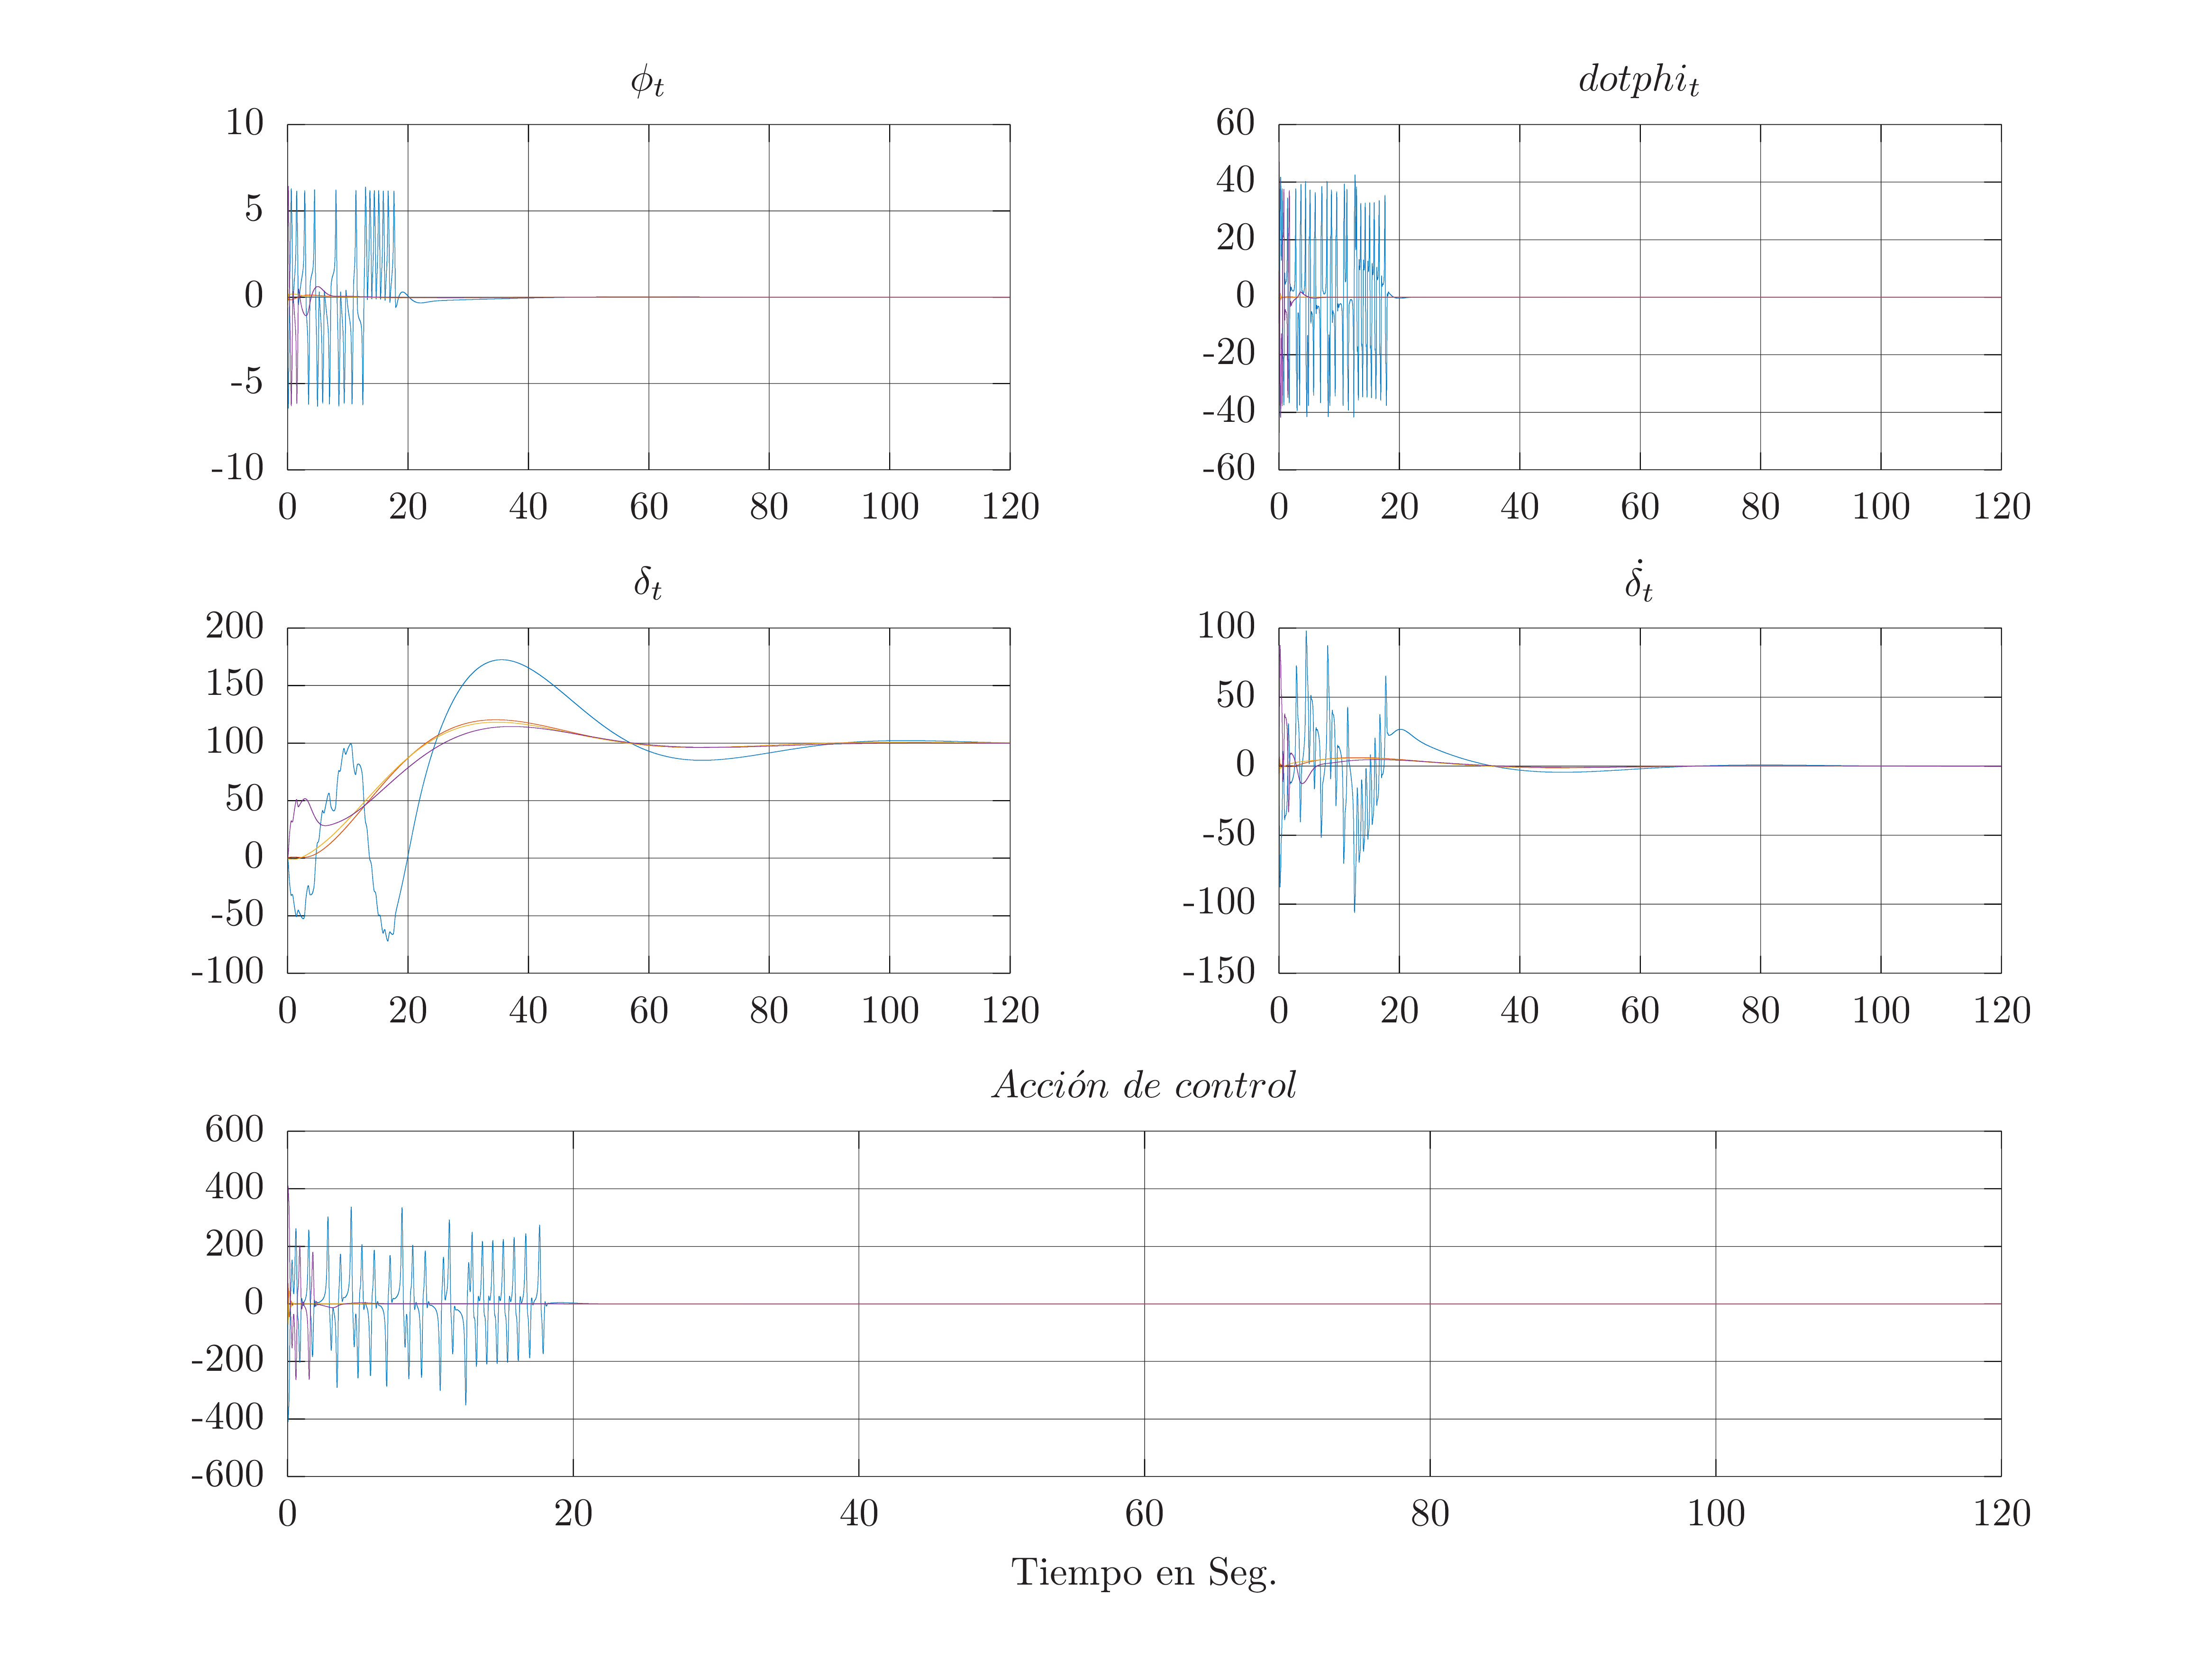

In [62]:
from PIL import Image
imt = Image.open("/content/Pendulo_t.png")
imt

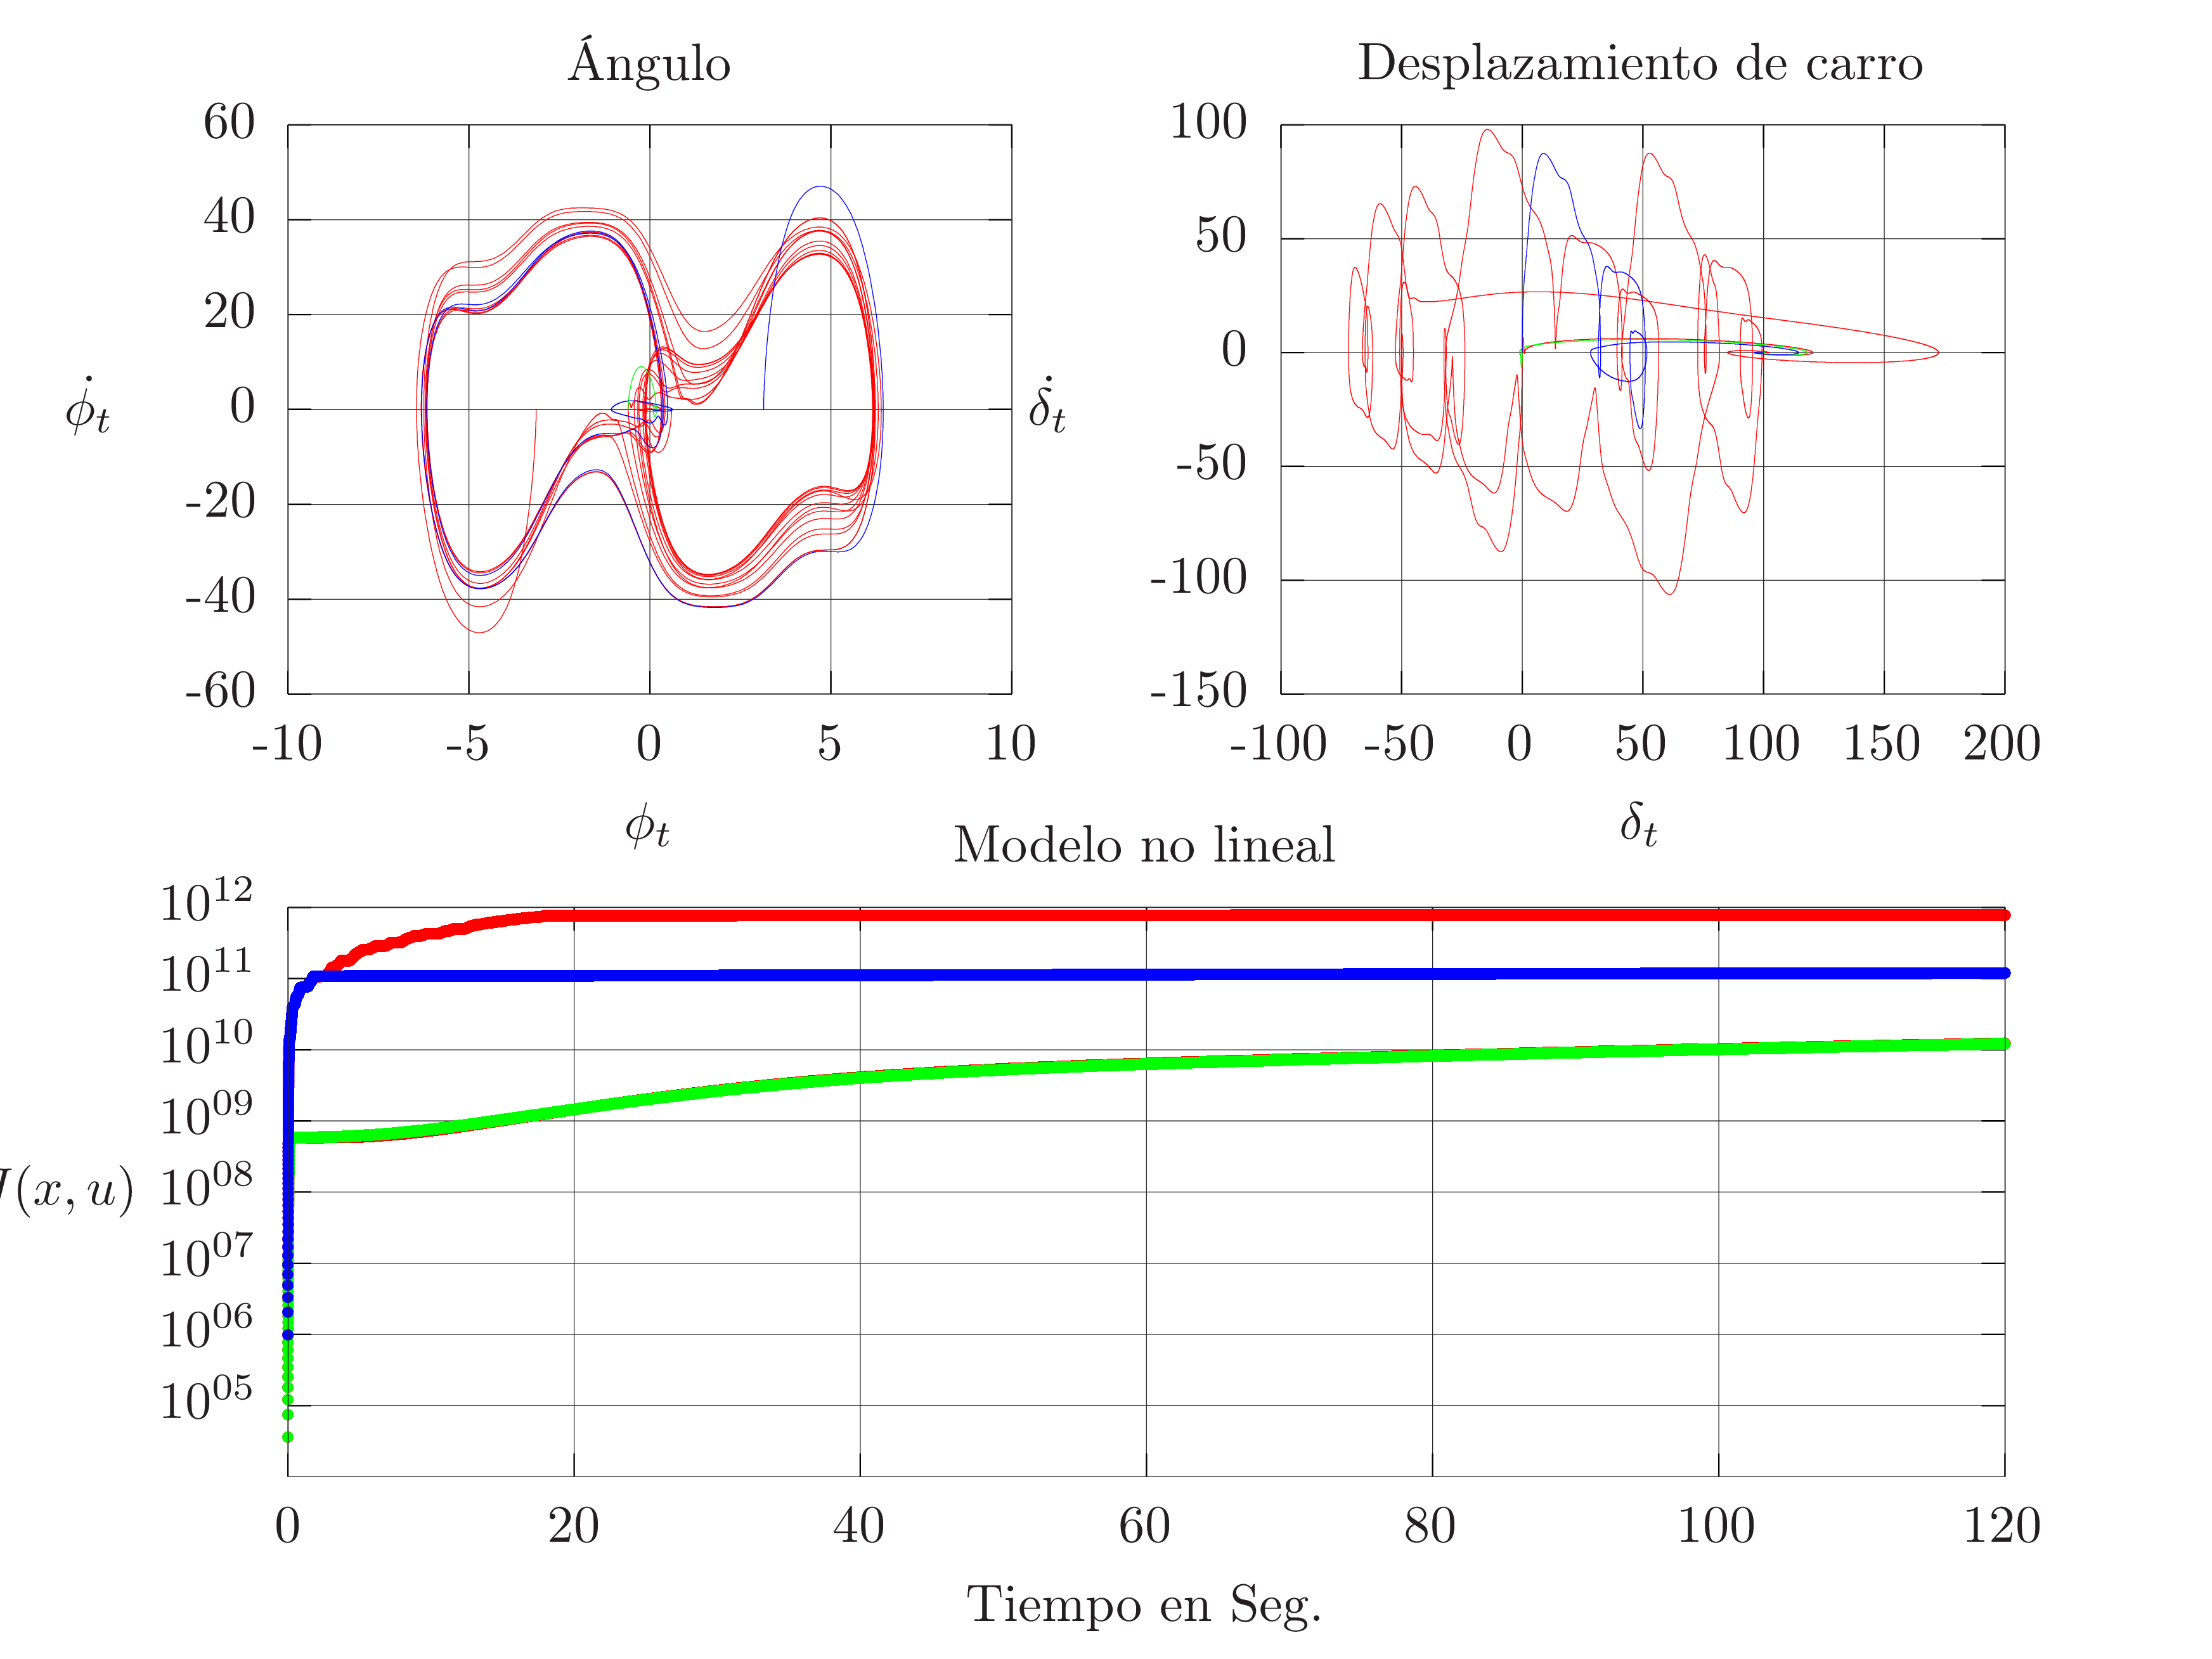

In [65]:
from PIL import Image
imt = Image.open("/content/Pendulo_fase.png")
imt

# Conclusiones

Se ha mostrado el desempeño de un controlador con observación de estados desarrollado por investigadores que trabajan en la temática.